In [82]:
%%capture
!pip install feature-engine
!pip install -U imbalanced-learn

In [117]:
import pandas as pd
import numpy as np
import sklearn as sk
import imblearn as imb # you should try different methods from this library!
from feature_engine import categorical_encoders as ce
from feature_engine import missing_data_imputers as mdi
from sklearn.pipeline import Pipeline # USE pipeline and LEARN
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
import warnings
warnings.filterwarnings("ignore")

In [84]:
submission_df   = pd.read_csv('inputs/sample_submission.csv')
df= pd.read_csv("inputs/train.csv")
test  = pd.read_csv("inputs/test.csv")

In [85]:
#Let's take the "Target" column from the train and delete the 'Id' and 'Target' columns from the train.
target = df["Target"]
df.drop(["Id", "Target"],axis=1, inplace=True)
test.drop(["Id"],axis=1, inplace=True)

In [86]:
miss_pct = df.isna().sum() / len(df) # Let's find the percentage of missing values for each column.
miss_pct

Var1      0.986286
Var2      0.974971
Var3      0.975000
Var4      0.968400
Var5      0.970229
            ...   
Var226    0.000000
Var227    0.000000
Var228    0.000000
Var229    0.570200
Var230    1.000000
Length: 230, dtype: float64

In [87]:
df = df.loc[:, miss_pct < 0.73]#then delete the columns with the missing value percentage greater than 75.
test = test.loc[:, miss_pct < 0.73]

In [88]:
#Lets find the numeric and nominal columns
categorical_cols = [var for var in df.columns
                       if df[var].dtype == 'O']
numerical_cols = [var for var in df.columns 
                     if df[var].dtype != 'O']

In [97]:
categorical_cols = [var for var in test.columns if df[var].dtype == 'O']
numerical_cols = [var for var in test.columns if df[var].dtype != 'O']

In [108]:
print("Categorical Columns: ", categorical_cols)
print("Numerical Columns: ", numerical_cols)

Categorical Columns:  ['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var200', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var214', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229']
Numerical Columns:  ['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var72', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var94', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var189']


In [109]:
preprocess_pipeline = Pipeline([
     # replace NA by the mean in variables below, they are numerical
     ('numerical_col_median_imputer', mdi.MeanMedianImputer(
            imputation_method='mean', variables = numerical_cols)),
    
     # replace NA by adding the most frequent value in categorical variables
      ('categorical_col_imputer', mdi.CategoricalVariableImputer(imputation_method = 'frequent', variables = categorical_cols)),
    
     # reduce the cardinality of categorical columns grouping rare values into "Rare" value
     ("cardinality_reduce", ce.RareLabelCategoricalEncoder(variables = categorical_cols)),
    
    # Categorical value to One-hot encoding
    ('categorical_to_ohe', ce.OneHotCategoricalEncoder(variables = categorical_cols)),
    
    # Normalize features
    ('normalizer',  StandardScaler()),
    
    # Logistic Regression for Classification Model

    ('classifier', CatBoostClassifier(n_estimators= 1500, learning_rate = 0.01, max_depth = 5, verbose = False,))
])

In [110]:
cv = sk.model_selection.StratifiedKFold(n_splits=5, random_state=2)
cross_val_scores = sk.model_selection.cross_val_score(preprocess_pipeline, df, target, cv=5, scoring='roc_auc')

In [111]:
cross_val_scores

array([0.87481941, 0.85746435, 0.86120562, 0.85153437, 0.86997063])

In [112]:
print("Mean of Stratified Cross Validation Score:", np.mean(cross_val_scores)) # This is the expected score for submission

Mean of Stratified Cross Validation Score: 0.8629988748762477


In [113]:
preprocess_pipeline.fit(df, target)# We are training our data science pipeline
submission_df['Target'] = preprocess_pipeline.predict_proba(test)[:, 1] # I will take the predictions

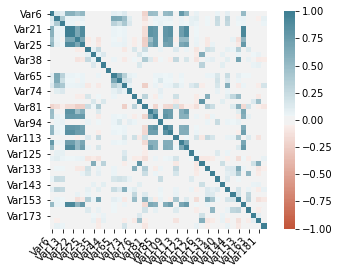

In [125]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [114]:
submission_df.head()

,Id,Target
0,29730,0.050189
1,492,0.087043
2,10955,0.050405
3,3531,0.078053
4,41398,0.014288


In [115]:
submission_df.to_csv("yusuf_güzel_final_submission.csv", index=False)